# How To: compute the energy terms, along with their derivatives.

This notebook shows how to compute the required energy and gradient functions. That will be used for the 

MeanFieldVarGP algorithm.

In [1]:
import os

import sys

import dill

import sympy as sym

from pathlib import Path

from sympy.stats import E, Normal

from sympy.utilities.iterables import flatten

from copy import deepcopy

PROJECT_DIR = os.path.abspath('..')

sys.path.append(PROJECT_DIR)

from src.numerical.symbolics import LagrangePolynomial

In [2]:
# Help make the output easier to read.
sym.init_printing(use_unicode=True)

# Objects referred to in the global dictionary are recursively traced and serialized.
dill.settings['recurse'] = True

## Dynamical System equations

To generate the equations we use the following settings.

In [ ]:
# |------------------|
# | Double Well (1D) |
# |------------------|
# 
# D = 1
# 
# p = sym.Matrix([sym.symbols("theta", real=True)])
# 
# fx = sym.Matrix((4 * xt) * (p - xt**2), real=True)
# 

# |-------------------------|
# | Ornstein-Uhlenbeck (1D) |
# |-------------------------|
# 
# D = 1
# 
# p = sym.Matrix([sym.symbols("theta mu", real=True)])
# 
# fx = sym.Matrix([p[0] * (p[1] - xt[0])], real=True)
# 

# |---------------|
# | Lorenz63 (3D) |
# |---------------|
# 
# D = 3
# 
# p = sym.Matrix([sym.symbols("sigma rho beta", real=True)])
#
# fx = sym.Matrix([p[0]*(xt[1] - xt[0]),
#                 xt[0]*(p[1] - xt[2]) - xt[1],
#                 xt[0]*xt[1] - p[2]*xt[2]], real=True);
# 

# |---------------|
# | Lorenz96 (nD) |
# |---------------|
# 
# D = 4
# 
# p = sym.Matrix([sym.symbols("theta", real=True)])
# 
# fx = sym.Matrix([(xt[1] - xt[3]) * xt[2] - xt[0] + p[0]], real=True)
# 

## First define the main variables.

In [3]:
# State vector dimensions.
D = 3

# Mean and variance functions: m(t), s(t).
mt = sym.symbols(f"m:{D+1}(t)", real=True)
st = sym.symbols(f"s:{D+1}(t)", real=True, positive=True)

# Random (state) vector: x(t).
xt = sym.Matrix([Normal(f"x{i}(t)", mt[i], sym.sqrt(st[i])) for i in range(D)])

# System noise (diffusion) coefficient vector: sig := sigma^2.
sig = sym.symbols(f"Sig:{D}", real=True, positive=True)

# Model (drift) parameters vector.
p = p = sym.Matrix([sym.symbols("sigma rho beta", real=True)])

# Drift function.
fx = sym.Matrix([p[0]*(xt[1] - xt[0]),
                xt[0]*(p[1] - xt[2]) - xt[1],
                xt[0]*xt[1] - p[2]*xt[2]], real=True)

# Number of systems dimensions.
# NOTE: this can be different from
#       the state vector dimensions!
dim_D = len(fx)

# Pretty printing.
sym.pprint(fx)

⎡   σ⋅(-x0(t) + x1(t))    ⎤
⎢                         ⎥
⎢(ρ - x2(t))⋅x0(t) - x1(t)⎥
⎢                         ⎥
⎣ -β⋅x2(t) + x0(t)⋅x1(t)  ⎦


## Compute the mean/variance Lagrange functions.

In [4]:
# Store the mean and variance functions.
Mfun = []
Sfun = []

# Store the time derivative of the mean and variance functions.
dMt = []
dSt = []

# Store the mean and variance points.
Mpar = []
Spar = []

# Create one polynomial for each state vector dimension.
for i in range(D):
    
    # Create the mean/variance polynomials.
    mt_i, t, mk_i, t_h = LagrangePolynomial(letter=f"d{i}m", order=3, fp="h")
    st_i, t, sk_i, t_c = LagrangePolynomial(letter=f"d{i}s", order=2, fp="c")
    
    # Store the functions.
    Mfun.append(mt_i)
    Sfun.append(st_i)
    
    # Store the Lagrange coefficients.
    Mpar.append(mk_i)
    Spar.append(sk_i)
    
    # Get the time derivative functions.
    dMt.append(mt_i.diff(t))
    dSt.append(st_i.diff(t))
    
# _end_for_

print("Done!")

Done!


## Compute the expectations.

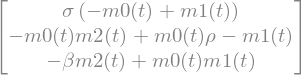

In [5]:
# E[f(x)]
Efx = E(fx).simplify(); Efx

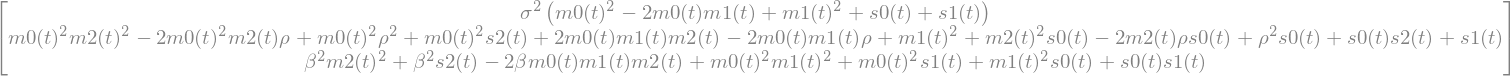

In [6]:
# E[f(x)^2]
Efx2 = E(fx.multiply_elementwise(fx)).simplify(); Efx2

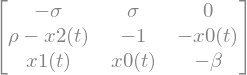

In [7]:
# Jacobian: dfx/dx
dfxdx = fx.jacobian(xt); dfxdx

In [8]:
# E[dfx/dx]
Edfxdx = E(dfxdx.diagonal()); Edfxdx

## Put all the $E_{sde}$ terms together.

These is given by the expression:

$E_{sde}(t) = \frac{1}{2} \sum_{i=1}^{D} \frac{1}{\sigma_{i}^2} \bigg( E[f_{i}^2]_{q_t} -2 E[f_{i}]_{q_t} \dot{m_i}(t) + \dot{m_i}^2(t) + \frac{(\dot{s_i}(t) - \sigma_{i}^2)^2}{4 s_{i}(t)} + (\sigma_{i}^2 - \dot{s_i}(t)) E\big[\frac{\partial f_i}{\partial x_i}\big]_{q_t}\bigg)$

where $E[\cdot]_{q_t}$ is the expected value with respect to the Gaussian process.

In essence the following cell computes all the terms inside the parenthesis (one for each dimension).

In [9]:
# Stores the Esde_i.
Esde = []

# Get the expression for each dimension.
for i in range(dim_D):
    
    # Display info.
    print(f"Estimating Esde_{i} ...")
    
    # Update the list.
    Esde.append(Efx2[i] - (2.0 * Efx[i] * dMt[i]) + dMt[i]**2 + (dSt[i] - sig[i])**2/(4.0 * Sfun[i]) + (sig[i] - dSt[i]) * Edfxdx[i])
    
# _end_for_

print("Done!")

Estimating Esde_0 ...
Estimating Esde_1 ...
Estimating Esde_2 ...
Done!


In [ ]:
# Print the energy functions.
for n, En in enumerate(Esde):
    print(n, ":")
    sym.pprint(En)

In [11]:
# Stores the parameterized Esde.
Esde_dk = []

# Count the succesful simplifications.
count_collect = 0

# Process each dimension separately.
for i in range(dim_D):
    
    # Display info.
    print(f"Processing dimension: {i} ...")
    
    # Initialize temporary result.
    tmp_Ei = deepcopy(Esde[i])
    
    # Replace the mean functions.
    for j, mf_j in enumerate(Mfun):
        tmp_Ei = tmp_Ei.replace(mt[j], mf_j)
    # _end_for_
    
    # Replace the variance functions.
    for j, sf_j in enumerate(Sfun):
        tmp_Ei = tmp_Ei.replace(st[j], sf_j)
    # _end_for_
    
    # Atempt a "collect" simplification.
    collect_expr = tmp_Ei.collect(Mpar[i]).collect(Spar[i])
    
    print(f"  Original expression ops: {sym.count_ops(tmp_Ei)}.")
    print(f"  Simplify expression ops: {sym.count_ops(collect_expr)}.")
    
    # Make sure the expressions are equal.
    if tmp_Ei.equals(collect_expr):
        
        # Append the simplified expression.
        Esde_dk.append(collect_expr)
        
        # Increase the success counter.
        count_collect += 1
    else:
        
        # Append the non-simplified expression.
        Esde_dk.append(tmp_Ei)
    # _end_if_
    
# _end_for_

print(f"Done! (Count collect = {count_collect}/{dim_D})")

Processing dimension: 0 ...
  Original expression ops: 755.
  Simplify expression ops: 736.
Processing dimension: 1 ...
  Original expression ops: 1531.
  Simplify expression ops: 1506.
Processing dimension: 2 ...
  Original expression ops: 1103.
  Simplify expression ops: 1084.
Done! (Count collect = 3/3)


In [ ]:
# Print the parameterized energy functions.
for l, Ei in enumerate(Esde_dk):
    
    print(f"Showing dimension {l}:\n")
    
    sym.pprint(Ei)
# _end_for_

print("Finished!")

## Compute the gradients.

In [12]:
# Define the gradient lists.
gradMp = []
gradSp = []

# Process each dimension separately.
for i in range(dim_D):
    
    # Display info.
    print(f"Calculating gradients for dimension: {i} ...")
    
    # Reset the lists for each dimension.
    gradMi = []
    gradSi = []
    
    # Derivatives with respect to the mean parameters.
    for dim_k in Mpar:
        for mk in dim_k:
            gradMi.append(Esde_dk[i].diff(mk))
        # _end_for_
    # _end_for_
    
    # Derivatives with respect to the variance parameters.
    for dim_k in Spar:
        for sk in dim_k:
            gradSi.append(Esde_dk[i].diff(sk))
        # _end_for_
    # _end_for_
    
    # Update the lists.
    gradMp.append(gradMi)
    gradSp.append(gradSi)
    
# _end_for_

print("Done!")

Calculating gradients for dimension: 0 ...
Calculating gradients for dimension: 1 ...
Calculating gradients for dimension: 2 ...
Done!


## Generating lambda functions.

In [13]:
# Lists to store the results.
func_Esde = []
grad_Esde_mt = []
grad_Esde_st = []

for i in range(dim_D):
    
    # Display information.
    print(f"Generating Lambda functions {i} ... ")
    
    func_Esde.append(sym.lambdify([t, *flatten([t_h, t_c, Mpar, Spar, sig, p])],
                                  Esde_dk[i], modules=["scipy", "numpy"], cse=True))
    
    grad_Esde_mt.append(sym.lambdify([t, *flatten([t_h, t_c, Mpar, Spar, sig, p])],
                                     gradMp[i], modules=["scipy", "numpy"], cse=True))

    grad_Esde_st.append(sym.lambdify([t, *flatten([t_h, t_c, Mpar, Spar, sig, p])],
                                     gradSp[i], modules=["scipy", "numpy"], cse=True))
# _end_for_

# Final message.
print("Done!")

Generating Lambda functions 0 ... 
Generating Lambda functions 1 ... 
Generating Lambda functions 2 ... 
Done!


## Save the functions to files.

In [ ]:
# Where to save the functions (parent directory).
# NOTE: We save the energy and the gradient (lambdified) functions in separate directories
# to improve the readability of the code. In practise they can be anywhere.
parent_path = Path("path/to/save/the/equations/of/MeanFieldVarGP/src/dynamical_systems")

for i in range(dim_D):
    
    with open(Path(parent_path/f"energy_functions/L63_Esde_{i}.sym"), "wb") as sym_file:
        
        dill.dump(func_Esde[i], sym_file)
        
    # _end_with_
    
    with open(Path(parent_path/f"gradient_functions/dL63_Esde_dM{i}.sym"), "wb") as sym_file:
        
        dill.dump(grad_Esde_mt[i], sym_file)
        
    # _end_with_
    
    with open(Path(parent_path/f"gradient_functions/dL63_Esde_dS{i}.sym"), "wb") as sym_file:
        
        dill.dump(grad_Esde_st[i], sym_file)
        
    # _end_with_
    
# _end_for_

print("Done!")

## End of notebook